<a href="https://colab.research.google.com/github/Nithish007B/YOLOv8-DeepSORT-Object-Tracking/blob/main/autonomous_driver_S_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google Doc File : https://docs.google.com/document/d/14BvO7FcM70Ti601LYFrhvsd2bOynnWx7zIw7ddQspVE/edit?usp=sharing

### Importing the log files, converting it to Pandas dataframe

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Multiple Drivers at once

In [33]:
import os
import pandas as pd
import numpy as np

def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c * 1000  # convert to meters

    return distance

def process_log_line(line):
    if "Feedback Code Starting" in line:
        return None

    sections = line.split(' :- ')

    if len(sections) != 2:
        return None

    log_timestamp = sections[0].strip().split(',')[0]
    log_details = sections[1].strip()

    details_parts = log_details.split(':')
    log_seq = details_parts[0]
    data_dict = {'Log_seq': int(log_seq)}

    mabx_values = [item.strip() for item in details_parts[1:]]
    data_dict['Timestamp'] = log_timestamp
    seq, veh_speed, tire_angle = map(float, mabx_values[0].split('||')[0].split(','))

    data_dict['MABX_seq'] = int(seq)
    data_dict['Veh_MABX_Speed'] = veh_speed
    data_dict['Tire_Angle'] = tire_angle

    gnss_values = mabx_values[0].split('||')[1].strip().split(',')
    if len(gnss_values) == 10:
        unixtime, lat, lng, lat_std, lng_std, gnss_speed, acc, roll, pitch, heading = map(float, gnss_values)
        data_dict['Lat'] = lat
        data_dict['Lng'] = lng
        data_dict['Lat_std'] = lat_std
        data_dict['Lng_std'] = lng_std
        data_dict['Veh_GNSS_Speed'] = gnss_speed
        data_dict['Z_Acc'] = acc
        data_dict['Roll'] = roll
        data_dict['Pitch'] = pitch
        data_dict['Heading'] = heading
    else:
        # print(f"Skipping line due to unexpected number of values: {len(gnss_values)} in line: {line}")
        return None

    return data_dict

def read_and_process_log_file(file_path, dataframe):
    with open(file_path, 'r') as file:
        file_content = file.read()

    file_lines = file_content.split('\n')

    data_list = []
    for line in file_lines:
        data_dict = process_log_line(line)
        if data_dict is not None:
            data_list.append(data_dict)

    if data_list:
        dataframe = pd.concat([dataframe, pd.DataFrame(data_list)], ignore_index=True)

    # # Extract date and time components from 'Timestamp' column
    # dataframe['Date'] = pd.to_datetime(dataframe['Timestamp']).dt.date
    # dataframe['Time'] = pd.to_datetime(dataframe['Timestamp']).dt.time

    return dataframe



data = {}

# Specify the file paths for different drivers
file_paths = [

              # '/content/drive/MyDrive/drivers-constant20'
            #   '/content/drive/MyDrive/drivers-constant20/aravind.log',
            # '/content/drive/MyDrive/drivers-constant20/nithish.log',
            #   '/content/drive/MyDrive/drivers-constant20/saisir.log',
            #   '/content/drive/MyDrive/drivers-constant20/santhosh.log'

      # # '/content/drive/MyDrive/Drivers-Data/rishav-auto35.log'
      #         # '/content/drive/MyDrive/Drivers-Data/rishav-auto1.log'
              '/content/drive/MyDrive/Drivers-Data/Speed20/aravind-20.log',
              '/content/drive/MyDrive/Drivers-Data/Speed20/rahul-20.log',
                '/content/drive/MyDrive/Drivers-Data/Speed20/sai-sir-20.log',
               '/content/drive/MyDrive/Drivers-Data/Speed20/santhosh-20.log',
      #           '/content/drive/MyDrive/Drivers-Data/Speed10/rahul-10.log',
      #           '/content/drive/MyDrive/Drivers-Data/Speed10/sai-sir-10.log',
      #           '/content/drive/MyDrive/Drivers-Data/Speed10/santhosh-10.log'
      #           # '/content/drive/MyDrive/Drivers-Data/Speed30/aravind-25.log',
      #           # '/content/drive/MyDrive/Drivers-Data/Speed30/rahul-25.log',
      #           # '/content/drive/MyDrive/Drivers-Data/Speed30/sai-sir-25.log',



]

# Process log files for each driver
for file_path in file_paths:
    driver_name = os.path.splitext(os.path.basename(file_path))[0]

    d1_folder = pd.DataFrame()

    # Initialize DataFrames for each type
    driver_df = pd.DataFrame()

    if os.path.exists(file_path) and os.path.isfile(file_path):
        driver_df = read_and_process_log_file(file_path, driver_df)
        driver_df['dist_from_start'] = haversine_vectorized(driver_df['Lat'][0], driver_df['Lng'][0], driver_df['Lat'], driver_df['Lng'])

        # Add the DataFrame to the main data dictionary using the driver name as the key
        data[driver_name] = {
            'driver_data': driver_df.copy(),
        }

        # Confirm that the DataFrame is not empty
        if data[driver_name]['driver_data'].empty:
            print(f"Empty DataFrame for {driver_name}")
    else:
        print(f"File not found: {file_path}")



In [ ]:
data['rahul-20']

In [ ]:
data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Some Information about the dataframe

In [ ]:
data['santhosh']


**CONSTANT20** **All drivers **

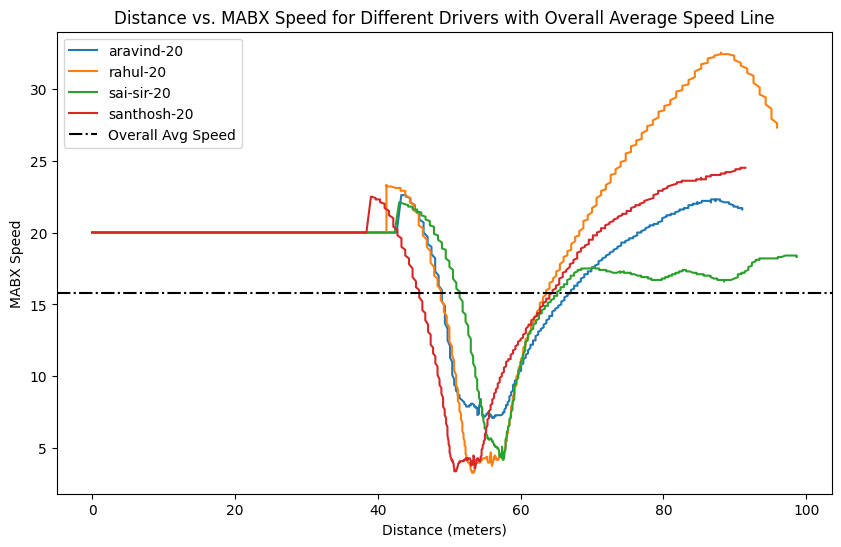

In [34]:
import matplotlib.pyplot as plt

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each driver in the data dictionary
for driver_name, driver_data in data.items():
    if 'driver_data' in driver_data and not driver_data['driver_data'].empty:
        # Get the driver's data
        driver_df = driver_data['driver_data']

        # Add the condition to filter data based on Z_Acc values
        filtered_df = driver_df[(driver_df['Z_Acc'] < 8) | (driver_df['Z_Acc'] > 14)]

        # Plot the distance vs. MABX speed
        ax.plot(driver_df['dist_from_start'], driver_df['Veh_MABX_Speed'], label=driver_name)

# Calculate the overall average speed
overall_avg_speed = pd.concat([driver_data['driver_data']['Veh_MABX_Speed'] for driver_data in data.values()]).mean()

# Add a horizontal line at the overall average speed
ax.axhline(y=overall_avg_speed, linestyle='-.', color='black', label=f'Overall Avg Speed')

# Set labels and title
ax.set_xlabel('Distance (meters)')
ax.set_ylabel('MABX Speed')
ax.set_title('Distance vs. MABX Speed for Different Drivers with Overall Average Speed Line')

# Add a legend
ax.legend()

# Show the plot
plt.show()



Single Driver with speed breaker

---



Driver 1 reaction start index: 225
Driver 1 reaction start distance: 46.97679333829833
Driver 1 speed breaker index: 0
Driver 1 speed breaker distance: 0.0
Driver 1 Reaction Distance: -46.98 m
Driver 2 reaction start index: 225
Driver 2 reaction start distance: 46.30376054696949
Driver 2 speed breaker index: 0
Driver 2 speed breaker distance: 0.0
Driver 2 Reaction Distance: -46.30 m
Driver 3 reaction start index: 239
Driver 3 reaction start distance: 47.86048936810977
Driver 3 speed breaker index: 0
Driver 3 speed breaker distance: 0.0
Driver 3 Reaction Distance: -47.86 m
Driver 4 reaction start index: 209
Driver 4 reaction start distance: 42.74923459775064
Driver 4 speed breaker index: 0
Driver 4 speed breaker distance: 0.0
Driver 4 Reaction Distance: -42.75 m


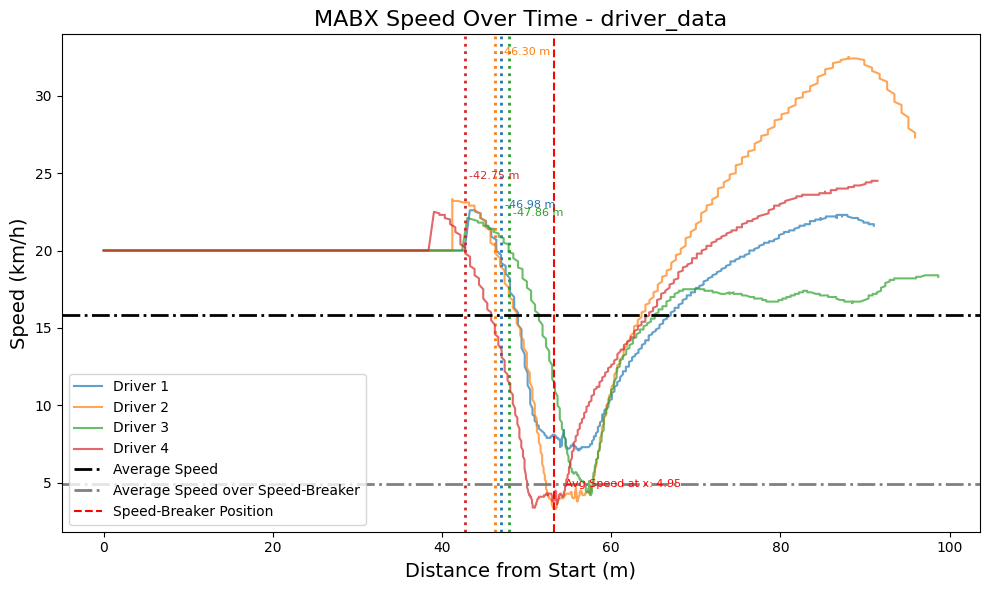

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Initialize a colormap
cmap = plt.get_cmap('tab10')

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Create a figure and a set of subplots
fig, axs = plt.subplots(num_datasets, 1, figsize=(10, 6 * num_datasets))

# Check if axs is a single axis object or an array
if num_datasets == 1:
    axs = [axs]

# Iterate through each dataset
for i, (df_name, df) in enumerate(next(iter(data.values())).items()):
    all_speeds = []
    x_value_speeds = []

    # Iterate through each user
    for j, (user_name, user_data) in enumerate(data.items()):
        user_df = user_data[df_name]

        # Extract x value based on the specified condition
        x_value = user_df.loc[(user_df['Z_Acc'] < 8) | (user_df['Z_Acc'] > 14), ['dist_from_start']]['dist_from_start'].values[3]

        all_speeds.extend(user_df['Veh_MABX_Speed'].tolist())
        x_value_speed = user_df.loc[user_df['dist_from_start'] == x_value, 'Veh_MABX_Speed'].values
        if x_value_speed.size > 0:
            x_value_speeds.append(x_value_speed[0])

        axs[i].plot(user_df['dist_from_start'], user_df['Veh_MABX_Speed'], label=f'Driver {j+1}', color=cmap(j % 10), alpha=0.7)

        # Find the index where the speed first drops below 15 km/h
        indices_below_20kmh = user_df['Veh_MABX_Speed'] < 20

        if indices_below_20kmh.any():
            index_for_reaction_start = indices_below_20kmh.idxmax()  # Finds the first True value
            reaction_start_distance = user_df.loc[index_for_reaction_start, 'dist_from_start']

            # Find the index for the speed at the speed breaker (3 km/h)
            index_for_speed_breaker = user_df['Veh_MABX_Speed'].searchsorted(3, side='left')
            speed_breaker_distance = user_df.loc[index_for_speed_breaker, 'dist_from_start'] if index_for_speed_breaker < len(user_df) else None

            # Debugging prints
            print(f"Driver {j+1} reaction start index: {index_for_reaction_start}")
            print(f"Driver {j+1} reaction start distance: {reaction_start_distance}")
            print(f"Driver {j+1} speed breaker index: {index_for_speed_breaker}")
            print(f"Driver {j+1} speed breaker distance: {speed_breaker_distance}")

            if speed_breaker_distance is not None:
                reaction_distance = speed_breaker_distance - reaction_start_distance

                 # Print the reaction distance
                print(f"Driver {j+1} Reaction Distance: {reaction_distance:.2f} m")

                # Plot a vertical line for the reaction start distance
                axs[i].axvline(x=reaction_start_distance, color=cmap(j % 10), linestyle=':', linewidth=2)

                # Annotate the reaction distance on the plot
                axs[i].annotate(f'{reaction_distance:.2f} m', xy=(reaction_start_distance, user_df['Veh_MABX_Speed'].max()),
                                xytext=(3, 0), textcoords="offset points", ha='left', va='bottom', color=cmap(j % 10), fontsize=8)

    # Average speed calculations
    avg_speed = np.mean(all_speeds)
    avg_x_value_speed = np.mean(x_value_speeds)

    # Plotting lines and annotations
    axs[i].axhline(y=avg_speed, color='black', linestyle='-.', label='Average Speed', linewidth=2)
    axs[i].axhline(y=avg_x_value_speed, color='grey', linestyle='-.', label='Average Speed over Speed-Breaker', linewidth=2)
    axs[i].axvline(x=x_value, color='red', linestyle='--', label='Speed-Breaker Position')
    axs[i].annotate(f'Avg Speed at x: {avg_x_value_speed:.2f}', (x_value, avg_x_value_speed), xytext=(8, 0),
                    textcoords='offset points', va='center', ha='left', fontsize=8, color='red')

    # Set labels and titles for each subplot
    axs[i].set_xlabel('Distance from Start (m)', fontsize=14)
    axs[i].set_ylabel('Speed (km/h)', fontsize=14)
    axs[i].set_title(f'MABX Speed Over Time - {df_name}', fontsize=16)
    axs[i].legend(loc='lower left', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()


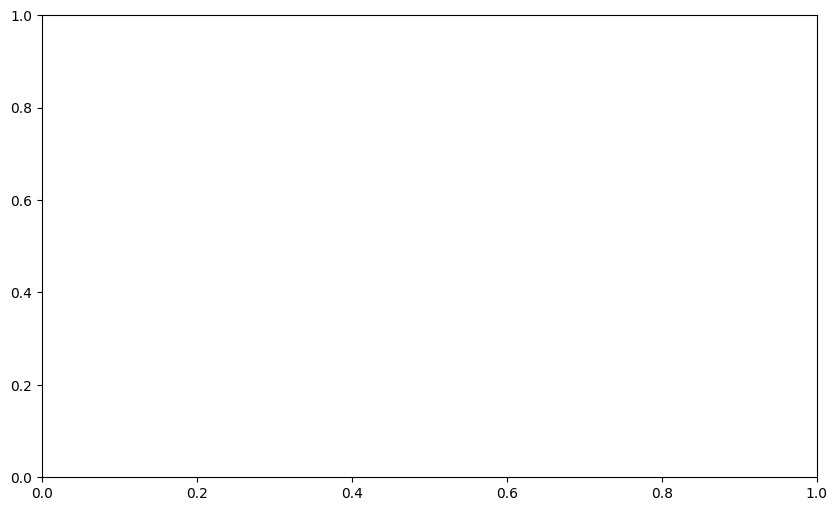

In [18]:
import pandas as pd
import matplotlib as plyt
import numpy as np

# Initialize a colormap
cmap = plt.get_cmap('tab10')

# initilizie the number user and userdatasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# print(num_datasets)

# ceate a figure and set of subplots
fig, axs = plt.subplots(num_datasets, 1, figsize=(10, 6*num_datasets))

# check if axs is a single line object or an array
if num_datasets ==1
   axs = [axs]

#





